# Sentinel-1 <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` test datacube environment
* **Products used:** 
s1_gamma0_scene
* **Prerequisites:** Read access of NCI project /g/data/dz56.


## Background

Sentinel 1A and 1B satellites, launched in 2014 and 2016 respectively, currently collects C-band SAR data every 12 days over Australia. Spatial resolution of the Sentinel-1 data is approximately 20m.

The current version of normalized backscatter (gamma0) product is processed to CARD4L recommendations, with corrections applied including orbit updates, border noise removal, thermal noise removal, radiometric calibration, radiometric terrain correction and orthorectification. Reference for this workflow can be found at https://doi.org/10.3390/data4030100

This product will be replaced when a different but compatible dataset becomes available in 2020. 

## Description
This notebook demonstrates how to load Sentinel-1 data using the `sarcube` wrapper. 
Topics covered include:

* Using the `sarcube` to load in Sentinel-1 backscatter data with default parameters.
* Creating a mean composite of Sentinel-1 backscatter.
* Using the `sarcube` to load in Sentinel-1 backscatter data with different speckle filter options.

***

## Getting started

The "Load packages" and "Connect to the datacube" cells must be executed first. 

### Load packages
Import Python packages that are used for the analysis.

In [3]:
%matplotlib inline

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
#import numpy as np
#import xarray as xr
import sys

sys.path.append('../Scripts')
from dea_sartools import sarcube


### Connect to the datacube

Use the `sarcube` wrapper to connect to the datacube. 
Sentinel-1 test data is not yet available through the production datacube so a configuration file is provided to connect to the test database.

In [5]:
dc = sarcube(app="Sentinel_1", config="../Supplementary_data/SAR_testcube/radar.conf")

## Load Sentinel-1 data

In [6]:
# check available bands for sentinel-1 data
dc.list_measurements().loc['s1_gamma0_scene']

,name,dtype,units,nodata,aliases,spectral_definition,flags_definition
measurement,,,,,,,
vh,vh,float32,1,0,NaN,NaN,NaN
vv,vv,float32,1,0,NaN,NaN,NaN
lia,lia,float32,1,0,"[local_incidence_angle, linci, incidence]",NaN,NaN


### Load data with default parameters

In [7]:
# create a query over Canberra
query = {'lon': (149.05, 149.15), 
         'lat': (-35.34, -35.26),
         'time': ('2018-07-01', '2018-08-31')
        }

In [8]:
# no speckle filter and convert output to decibel 
data = dc.load(product='s1_gamma0_scene', 
               group_by='solar_day',
               **query)

In [9]:
# filter with lia
mask = data.lia < 60
data = data.where(mask)

In [10]:
# add a ratio band for visualisation
# use subtraction in db (log) space 
data['vhvv'] = data.vh - data.vv

In [11]:
# rescale the data for improved contrast
m, s = data[['vv','vh','vhvv']].mean(), data[['vv','vh','vhvv']].std()
arr = (data[['vv','vh','vhvv']] - m)/s

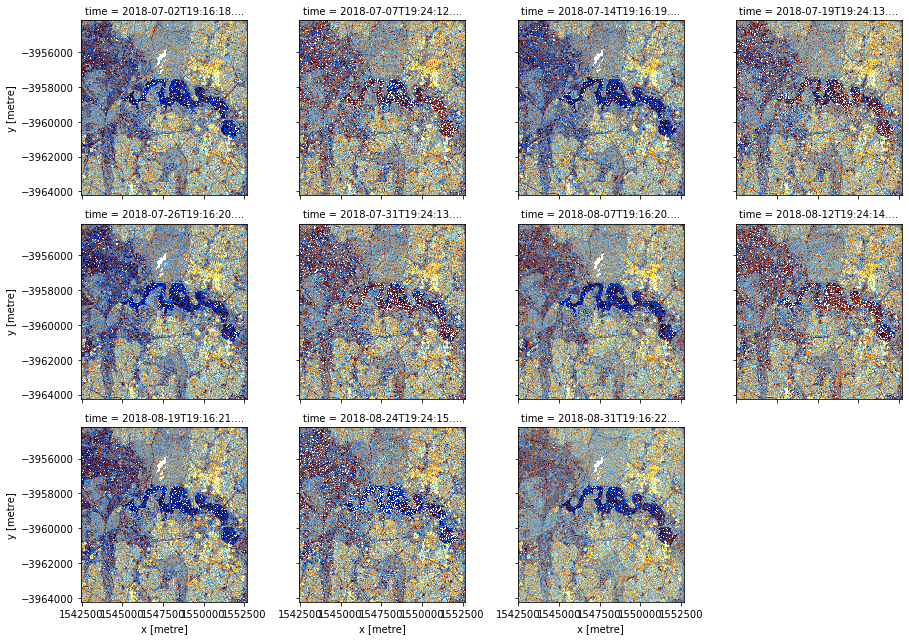

In [12]:
arr.to_array().plot.imshow(robust=True, col='time', col_wrap=4);

## Create monthly mean composites

In [13]:
data_mean = data[['vv','vh']].groupby('time.month').mean(dim='time')
data_mean['vhvv'] = data_mean.vh - data_mean.vv

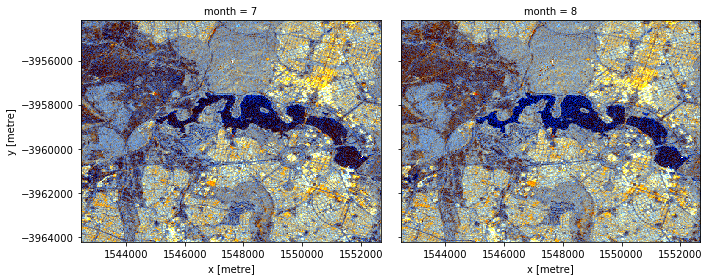

In [14]:
# rescale the data for improved contrast
m, s = data_mean[['vv','vh','vhvv']].mean(), data_mean[['vv','vh','vhvv']].std()
arr_mean = (data_mean[['vv','vh','vhvv']] - m)/s
arr_mean.to_array().plot.imshow(robust=True, col='month', figsize=(10,4));

## Load data with different speckle filter options

In [15]:
query = {'lon': (149.09, 149.12), 
         'lat': (-35.30, -35.27),
         'time': ('2019-06-01', '2019-12-31')
        }
dss = dc.find_datasets(product='s1_gamma0_scene',**query)

In [16]:
# load and convert to decibel
data_db = dc.load(product='s1_gamma0_scene', 
                  speckle_filter=None, db=True, verbose=True, 
                  datasets=[dss[0]],
                  measurements=['vv','vh'],
                  group_by='solar_day', 
                  resampling='bilinear',
                  **query)

Converting to db...


In [17]:
# load, apply lee filter and convert to decibel
data_lee = dc.load(product='s1_gamma0_scene', 
                   speckle_filter='lee', filter_size=5, db=True, verbose=True, 
                   datasets=[dss[0]],
                   measurements=['vv','vh'],
                   group_by='solar_day', 
                   resampling='bilinear',
                   **query)

Applying a lee filter with window size of 5...
Converting to db...


In [18]:
# load all data, apply temporal filter, convert to decibel and keep relevant timeslice
data_temporal = dc.load(product='s1_gamma0_scene', 
                        speckle_filter='temporal', filter_size=3, db=True, verbose=True, 
                        datasets=dss,
                        measurements=['vv','vh'],
                        group_by='solar_day', 
                        resampling='bilinear', 
                        **query).sel(time=data_db.time.values[0])

Applying a temporal filter with window size of 3...
Converting to db...


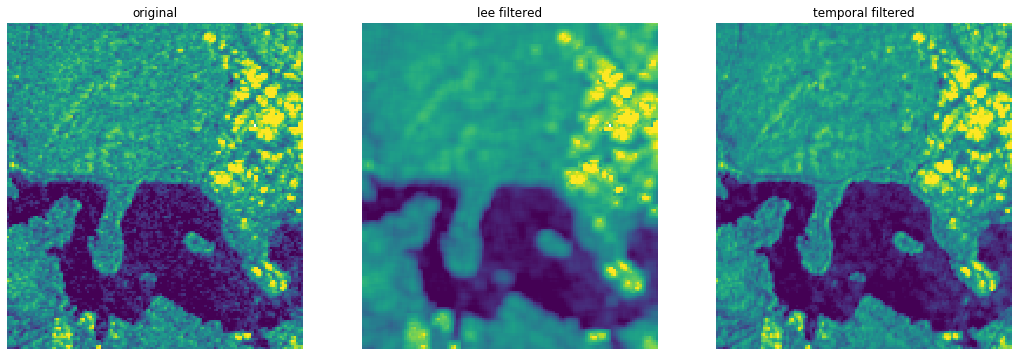

In [19]:
f, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
band = 'vv'
vmin, vmax = -20, 0
data_db.isel(time=0)[band].plot.imshow(add_colorbar=False, vmin=vmin, vmax=vmax, ax=ax[0]);
ax[0].set_title('original');
data_lee.isel(time=0)[band].plot.imshow(add_colorbar=False, vmin=vmin, vmax=vmax, ax=ax[1]);
ax[1].set_title('lee filtered');
data_temporal[band].plot.imshow(add_colorbar=False, vmin=vmin, vmax=vmax, ax=ax[2]);
ax[2].set_title('temporal filtered');


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [20]:
import datacube
print(datacube.__version__)

1.7+142.g7f8581cf


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)